In [1]:
# Dependencies
import requests
from pprint import pprint
from config import api_key
import pandas as pd
import time
from datetime import datetime, date
from dateutil.relativedelta import relativedelta, MO
import matplotlib.pyplot as plt
url = "https://api.nytimes.com/svc/search/v2/articlesearch.json?"
#https://api.nytimes.com/svc/search/v2/articlesearch.json?q=election&api-key=yourkey
company = "Netflix"

In [2]:
# Search for articles that mention company name
query = company

In [3]:
# Build query URL
query_url = url +"q=" + query + "&fq=news_desk:(Business)&page=0&sort=newest&api-key=" + api_key
#print(query_url)

In [4]:
# Request articles
articles = requests.get(query_url).json()

# The "response" property in articles contains the actual articles
# list comprehension.
articles_list = articles["response"]["docs"]


In [5]:
# Print the web_url of each stored article
print("Your Reading List")
reading_list = []
for article in articles_list[:5]:
    reading_list.append(article["web_url"])
    print(article["web_url"])

Your Reading List
https://www.nytimes.com/2021/01/04/business/media/04economy-briefing-quibi-sale-content-roku.html
https://www.nytimes.com/2021/01/03/business/media/streaming-shows-discovery.html
https://www.nytimes.com/2020/12/31/business/three-body-problem-murder-poison.html
https://www.nytimes.com/2020/12/27/business/media/dc-superheroes-movies.html
https://www.nytimes.com/2020/12/24/business/media/dissident-jamal-khashoggi-netflix-amazon.html


In [6]:
reading_list

['https://www.nytimes.com/2021/01/04/business/media/04economy-briefing-quibi-sale-content-roku.html',
 'https://www.nytimes.com/2021/01/03/business/media/streaming-shows-discovery.html',
 'https://www.nytimes.com/2020/12/31/business/three-body-problem-murder-poison.html',
 'https://www.nytimes.com/2020/12/27/business/media/dc-superheroes-movies.html',
 'https://www.nytimes.com/2020/12/24/business/media/dissident-jamal-khashoggi-netflix-amazon.html']

In [7]:
feature_article = articles_list[0]

In [8]:
feature_article_url = feature_article["web_url"]
feature_article_name = feature_article["headline"]["main"]
feature_image_link = "https://www.nytimes.com/" + feature_article["multimedia"][0]["url"]
feature_article_lead = feature_article["lead_paragraph"]

In [9]:
print(feature_article_name)
print(feature_article_lead)
print(f"Article Link: {feature_article_url}")
print(f"Image Link: {feature_image_link}")

Quibi Is Dead, but Roku May Resurrect Its Content
Quibi was the biggest bust of the streaming boom. But it has something Roku wants — more than 100 original programs.
Article Link: https://www.nytimes.com/2021/01/04/business/media/04economy-briefing-quibi-sale-content-roku.html
Image Link: https://www.nytimes.com/images/2021/01/04/business/04ECON-BRIEFING-QUIBI/04ECON-BRIEFING-QUIBI-articleLarge.jpg


In [10]:
articles_df = pd.read_csv('articles.csv')
articles_df.head()

,Date
0,1/01/2010
1,1/01/2011
2,1/01/2012
3,1/01/2013
4,1/01/2014


In [15]:
articles_df["Articles"] = ''
for index, row in articles_df.iterrows():
    try:
        query = company
        date = datetime.strptime(row['Date'], '%d/%m/%Y').date()
        begin_date = date.strftime('%Y%m%d')
        end_date = (date + relativedelta(years=+1)).strftime('%Y%m%d')
        url = f"https://api.nytimes.com/svc/search/v2/articlesearch.json?api-key={api_key}&q={query}&begin_date={begin_date}&end_date={end_date}"
        #print(url)
        article = requests.get(url).json()
        time.sleep(2)
        articles_df.loc[index, "Articles"] = article['response']['meta']['hits']
        
    except KeyError:
        print (f"{begin_date} - Cannot Search")

    

In [16]:
articles_df.head()

,Date,Articles
0,1/01/2010,244
1,1/01/2011,362
2,1/01/2012,299
3,1/01/2013,470
4,1/01/2014,678


In [17]:
articles_df.to_csv("articles_loaded.csv",index=False)

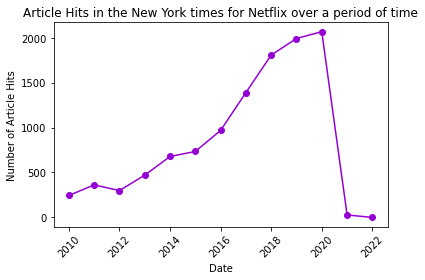

<Figure size 432x288 with 0 Axes>

In [18]:
articles_df['Date'] = pd.to_datetime(articles_df['Date'])
articles_df.sort_values('Date', inplace=True)

articles_df['Articles'] = pd.to_numeric(articles_df['Articles'])

articles_df = articles_df.fillna(0)

plt.plot(articles_df[articles_df.columns[0]],articles_df[articles_df.columns[1]], color = "darkviolet", marker ="o")

plt.xlabel("Date")
plt.ylabel("Number of Article Hits")
plt.title(f"Article Hits in the New York times for {company} over a period of time")
plt.xticks(rotation = 45)

plt.tight_layout()
# Show the chart
plt.show()
plt.savefig("article_hits.png")